In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor

import os
from collections import defaultdict

%matplotlib inline

# Drone Flight Analysis
Derek Halliwell

---

The purpose of this notebook is to identify anomalies in the flight data and determine which factors contribute to these anomalies.

I identify anomalies by calculating differences in successive time series values for each signal variable. If the difference is more than 3 standard deviations away from the mean difference value for that variable, I will flag that individual measurement as an anomaly.

I am looking for sudden changes in the recorded flight measurements. This could indicate a discontinuity in the data or an external factor that affects the bearing of the drone.

### Aggregate Flight Data

In [2]:
summ = pd.read_csv('data/summary_data.csv')
summ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 14 columns):
flight_id                447 non-null int64
air_temperature          447 non-null float64
battery_serial_number    447 non-null object
body_serial_number       447 non-null int64
commit                   447 non-null object
launch_airspeed          447 non-null float64
launch_groundspeed       447 non-null float64
launch_timestamp         447 non-null object
preflight_voltage        431 non-null float64
rel_humidity             447 non-null float64
static_pressure          447 non-null float64
wind_direction           447 non-null float64
wind_magnitude           447 non-null float64
wing_serial_number       447 non-null object
dtypes: float64(8), int64(2), object(4)
memory usage: 49.0+ KB


We are missing values for preflight voltage. I will replace these missing values with the average voltage values.

In [3]:
summ.loc[summ['preflight_voltage'].isnull(),'preflight_voltage'] = summ['preflight_voltage'].mean()

# Datetime attributes
summ['launch_timestamp'] = pd.to_datetime(summ['launch_timestamp'].str.slice(0,-3))
summ['launch_day_of_week'] = summ['launch_timestamp'].dt.weekday
summ['launch_month'] = summ['launch_timestamp'].dt.month
summ['launch_day'] = summ['launch_timestamp'].dt.day
summ['launch_hour'] = summ['launch_timestamp'].dt.hour

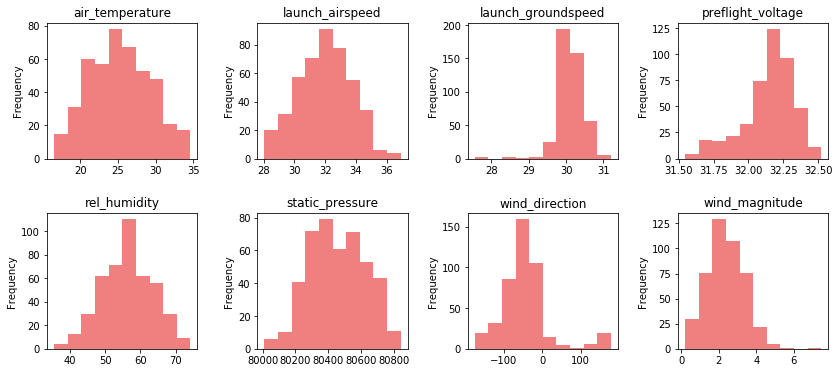

In [4]:
# Histograms for numerical columns
numeric_cols = [col for col in summ.select_dtypes('float64')]

plot_cols = 4
plot_rows = int(len(numeric_cols)/plot_cols)

fig, ax = plt.subplots(nrows=plot_rows,
                       ncols=plot_cols,
                       figsize=(14,6))
ax = ax.flatten()

for i,col in enumerate(numeric_cols):
    summ[col].plot.hist(title=col,ax=ax[i],color='lightcoral')
    
plt.subplots_adjust(wspace=0.4,hspace=0.4)

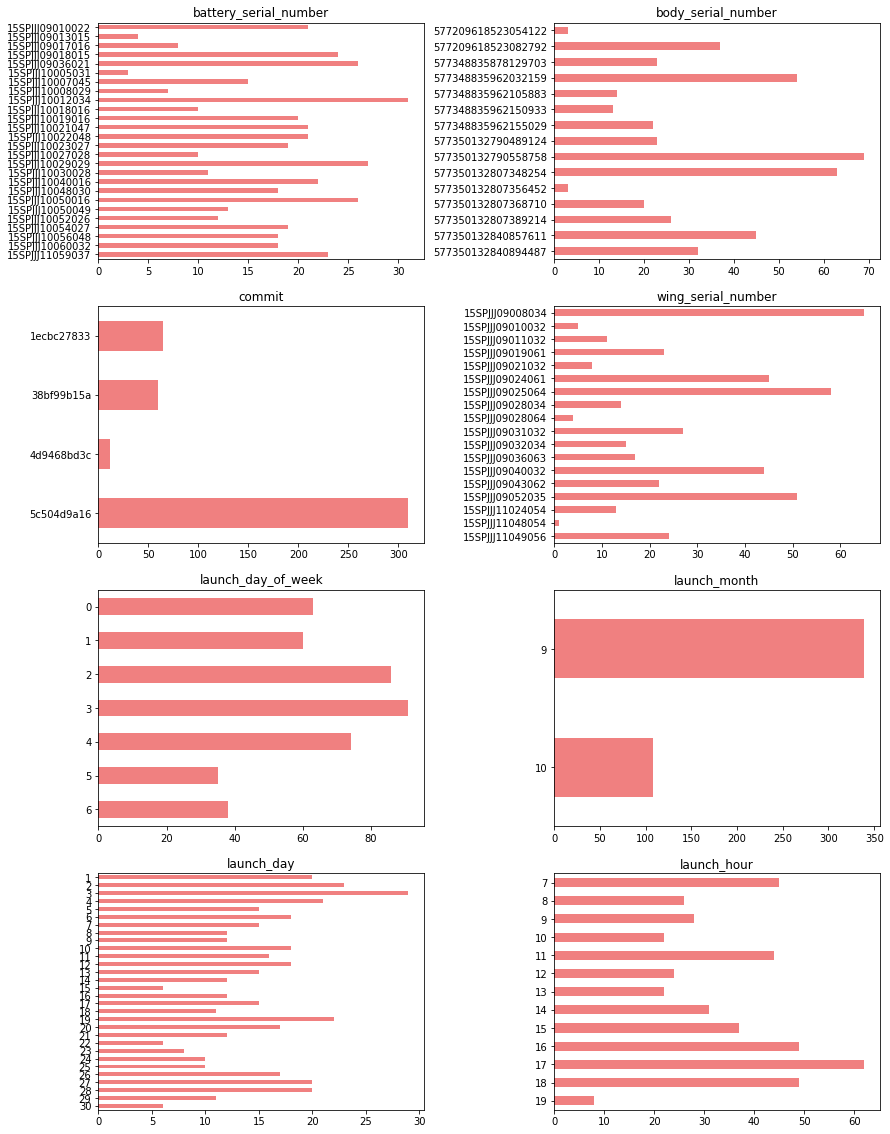

In [5]:
# Value_counts for Categorical Columns
categ_cols = [col for col in summ.columns if col not in numeric_cols + ['flight_id'] + ['launch_timestamp']]

plot_cols = 2
plot_rows = int(len(categ_cols)/plot_cols)

fig, ax = plt.subplots(nrows=plot_rows,
                       ncols=plot_cols,
                       figsize=(14,20))
ax = ax.flatten()

for i,col in enumerate(categ_cols):
    vc = summ[col].value_counts().sort_index(ascending=False)
    vc.plot.barh(title=col,ax=ax[i],color='lightcoral')
    
plt.subplots_adjust(wspace=0.4)

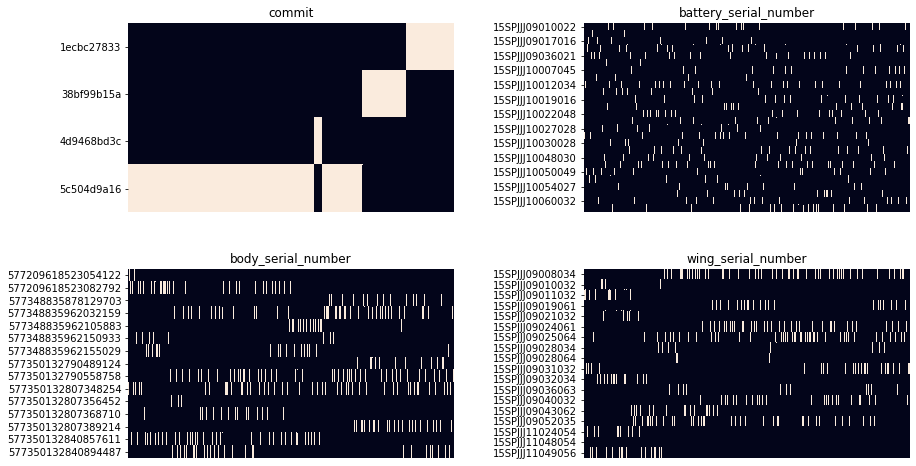

In [6]:
# Plot of component usage over time
components = ['commit',
              'battery_serial_number',
              'body_serial_number',
              'wing_serial_number']

fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       figsize=(14,8))
ax = ax.flatten()

for i,col in enumerate(components):
    df = pd.get_dummies(summ.sort_values('launch_timestamp')[col])
    
    sns.heatmap(df.T,
                cbar=None,
                ax=ax[i],
                xticklabels=False)
    
    ax[i].set_title(col)
    
plt.subplots_adjust(wspace=0.4,hspace=0.3)

### In-flight Measurements

In [7]:
# Load all flight files
path = 'data/'

file_names = [file for file in os.listdir(path) if file.startswith("flight") & file.endswith(".csv")]

dfs = []

for file_name in file_names:
    df = pd.read_csv(path + str(file_name))
    df['flight_num'] = file_name.replace('_', '.').split('.')[1]
    df['flight_num'] = df['flight_num'].astype(int)
    dfs.append(df)

flights = pd.concat(dfs)

In [8]:
# Check for missing values
flights.isnull().any()

seconds_since_launch          False
position_ned_m[0]             False
position_ned_m[1]             False
position_ned_m[2]             False
velocity_ned_mps[0]           False
velocity_ned_mps[1]           False
velocity_ned_mps[2]           False
accel_body_mps2[0]            False
accel_body_mps2[1]            False
accel_body_mps2[2]            False
orientation_rad[0]            False
orientation_rad[1]            False
orientation_rad[2]            False
angular_rate_body_radps[0]    False
angular_rate_body_radps[1]    False
angular_rate_body_radps[2]    False
position_sigma_ned_m[0]       False
position_sigma_ned_m[1]       False
position_sigma_ned_m[2]       False
flight_num                    False
dtype: bool

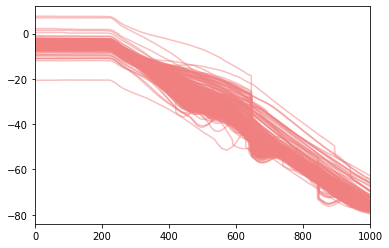

In [9]:
flights.groupby('flight_num')['position_ned_m[2]'].plot.line(alpha=0.5,c='lightcoral');

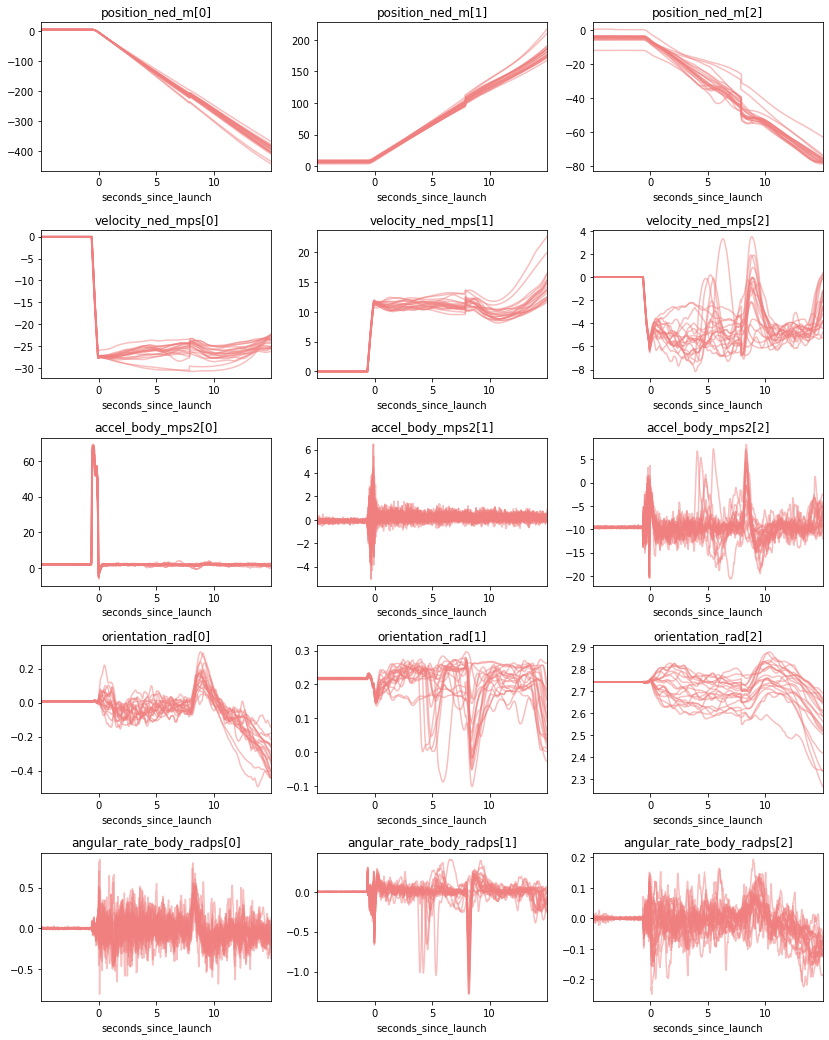

In [10]:
def flights_visualizer(df):
    """
    Group by flight number and plot in-flight measurements over time.
    
    """
    
    x = 'seconds_since_launch'
    
    y_names = ['position_ned_m',
               'velocity_ned_mps',
               'accel_body_mps2',
               'orientation_rad',
               'angular_rate_body_radps']
    
    fig,ax = plt.subplots(nrows=len(y_names),
                          ncols=3,
                          figsize=(14,18))
    
    plt.subplots_adjust(hspace=0.4)

    for i,y_name in enumerate(y_names):
        for j in range(3):   
            y = y_name + '[{}]'.format(j)
            grouped = df.groupby('flight_num')[[x,y]]
            grouped.plot.line(x=x,y=y,
                              ax=ax[i][j],
                              legend=False,
                              title=y,
                              c='lightcoral',alpha=0.5);
            
# Sample 20 flights
sample_flight_nos = flights['flight_num'].sample(20)
sample_flights = flights[flights['flight_num'].isin(sample_flight_nos)]
            
flights_visualizer(sample_flights)

Looking at the flight measurements, we can clearly see the catapult in action. To get an accurate picture of flight data, I will only include data 0.5 seconds after launch. This will remove any effects the catapult has on our measurements.  

In [11]:
flights = flights[0.5 < flights['seconds_since_launch']]

In [12]:
def find_anomalies(df):
    """
    Input: dataframe of in-flight measurements
    
    Output: Modified dataframe with column for  and 
    anomaly flags for each measurement column.
    
    Outlier methodology:
    
    For each measurement column, I will compare each value to
    the value recorded immediately prior. If this difference is outside of
    3 standard deviations from the mean difference value for that measurement,
    I will flag that individual measurement as an anomaly.
    
    """
    y_names = ['position_ned_m',
               'velocity_ned_mps',
               'accel_body_mps2',
               'orientation_rad',
               'angular_rate_body_radps']
    
    cols = [name+'[{}]'.format(i) for name in y_names for i in range(3)]
    
    # Compare each value to previous value in column
    diff_cols = []
    
    for col in cols:
        diff_col = 'diff_' + col
        df.loc[:,diff_col] = df[col] - df[col].shift(1)         
        diff_cols.append(diff_col)
    
    # Flag anomalies in each difference column
    anom_cols = []
    
    for diff_col in diff_cols:
        mean = df[diff_col].mean()
        std = df[diff_col].std()
        
        bounds = (mean - 3*std, mean + 3*std)
        
        anom_col = 'anom_' + diff_col
        
        df.loc[:,anom_col] = (~df[diff_col].between(min(bounds),max(bounds)))
        df.loc[:,anom_col] = df.loc[:,anom_col].astype(int)
        
        anom_cols.append(anom_col)
        
    # Clear anomalies for first row since no differences are computed here
    df.loc[df.index.min(),anom_cols] = 0
    
    return df

In [13]:
# Find anomalies in each flight
groups = flights.groupby('flight_num')

dfs = []

for name, group in groups:
    df = find_anomalies(group.copy())
    df.loc[:,'flight_num'] = name
    dfs.append(df)
    
flights2 = pd.concat(dfs)

In [14]:
diff_cols = [col for col in flights2.columns if col.startswith('diff')] 
anom_cols = [col for col in flights2.columns if col.startswith('anom')]

anomalies = flights2.groupby('flight_num')[anom_cols].sum().sum(1)
anomalies = pd.DataFrame(anomalies,columns=['anomaly_count'])

anomalies.head()

,anomaly_count
flight_num,
16951,113
16952,124
16954,103
16955,111
16957,121


In [15]:
def visualize_anomalies(df, flight_num):
    df_filtered = df[df['flight_num'] == flight_num]

    plt.figure(figsize=(10, 4))
    plt.title('Flight Number ' + str(df_filtered['flight_num'].max()))

    sns.heatmap(df_filtered[anom_cols].T,cbar=False,xticklabels=False)

    plt.show()

The followng heatmaps illustrate the differences between flights with low and high anomaly counts, respectively.

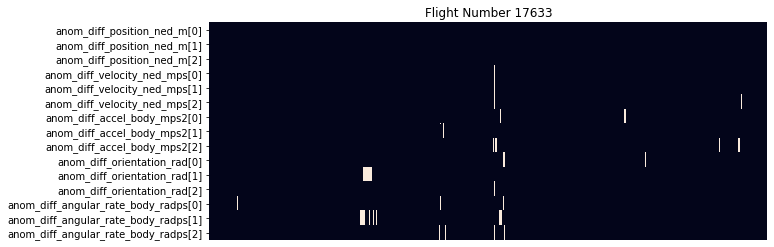

In [16]:
# Flight with fewer anomalies (67)
visualize_anomalies(flights2, 17633)

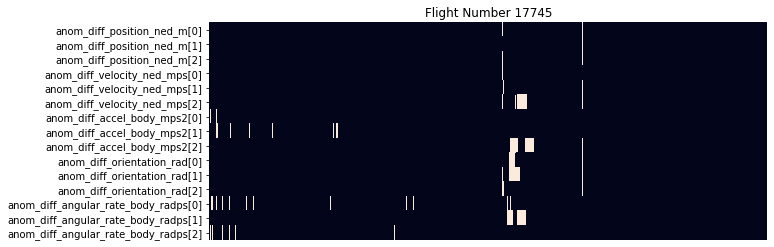

In [17]:
# Flight with more anomalies (133)
visualize_anomalies(flights2, 17745)

# Analysis of Anomalies

Here we will look at the flight characteristics that could explain the number of observed anomalies per flight.

In [18]:
summ = summ.merge(anomalies,
                  left_on='flight_id',
                  right_index=True)

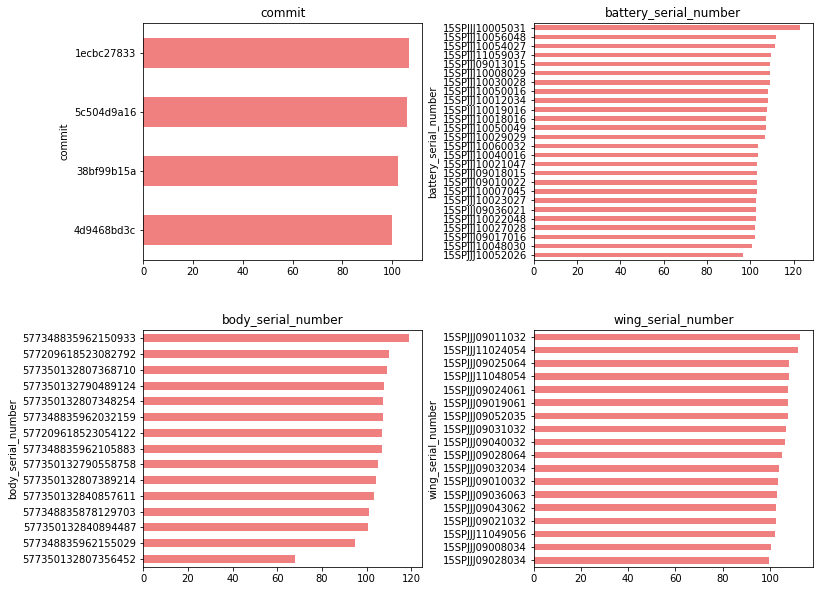

In [19]:
# Average anomaly count by component
components = ['commit',
              'battery_serial_number',
              'body_serial_number',
              'wing_serial_number']

fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       figsize=(12,10))
ax = ax.flatten()

for i,col in enumerate(components):
    gb = summ.groupby(col)['anomaly_count'].mean()
    
    gb.sort_values().plot.barh(ax=ax[i],color='lightcoral')
    
    ax[i].set_title(col)
    
plt.subplots_adjust(wspace=0.4,hspace=0.3)

We see some parts that are worth investigating, particularly body serial number XXXX0933 and battery serial number XXXX5031.

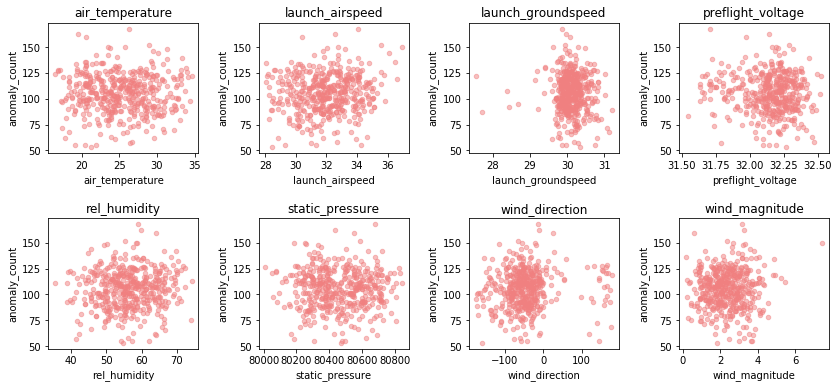

In [20]:
# Scatterplots of numeric features and anomaly count 
plot_cols = 4
plot_rows = int(len(numeric_cols)/plot_cols)

fig, ax = plt.subplots(nrows=plot_rows,
                       ncols=plot_cols,
                       figsize=(14,6))
ax = ax.flatten()

for i,col in enumerate(numeric_cols):
    summ.plot.scatter(x=col,y='anomaly_count',title=col,ax=ax[i],color='lightcoral',alpha=0.5)
    
plt.subplots_adjust(wspace=0.4,hspace=0.5)

There are no obvious patterns here, but these features could be useful in a predictive model.

### Feature Importances from Decision Tree Regressor

In [21]:
X = summ.drop(['launch_timestamp','flight_id','anomaly_count'],axis=1)
y = summ['anomaly_count']

# Encode categorical columns
labels = defaultdict(LabelEncoder)

X.loc[:,categ_cols] = X.loc[:,categ_cols].apply(lambda x: labels[x.name].fit_transform(x))

In [22]:
X.head()

,air_temperature,battery_serial_number,body_serial_number,commit,launch_airspeed,launch_groundspeed,preflight_voltage,rel_humidity,static_pressure,wind_direction,wind_magnitude,wing_serial_number,launch_day_of_week,launch_month,launch_day,launch_hour
0,20.550000,4,9,3,32.453445,30.164656,32.145665,74.150000,80662.081736,-49.434555,1.949338,15,3,0,5,0
1,20.500000,15,0,3,32.141209,30.535246,32.145665,71.175044,80708.065314,-4.408768,0.917357,2,3,0,5,0
2,24.475019,8,0,3,34.701878,29.872613,32.145665,66.374982,80774.270438,-23.458781,3.788383,2,3,0,5,2
3,27.300000,22,1,3,34.368999,29.877624,32.145665,59.000000,80805.138793,-46.747881,3.921605,17,3,0,5,3
4,26.950000,20,5,3,32.898979,30.027183,32.145665,63.900000,80768.969307,-29.293360,2.975881,9,3,0,5,4


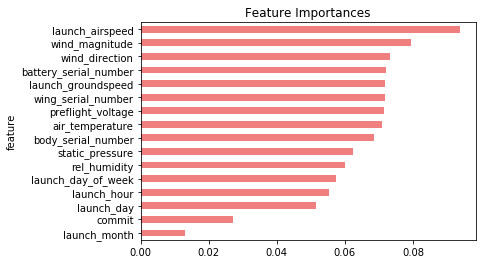

In [23]:
forest = ExtraTreesRegressor(n_estimators=500,
                             random_state=0)
forest.fit(X, y)

importances = pd.DataFrame({'feature':X.columns,
                            'importance':forest.feature_importances_})

importances = importances.sort_values('importance',ascending=True)
importances.plot(x='feature',
                 kind='barh',
                 legend=False,
                 title='Feature Importances',
                 color='lightcoral');

When predicting the number of anomalies seen per flight, we see launch airspeed and wind magnitude explaining the most variation in anomaly counts. We also see certain components being useful to this model.

# Next Steps

A limitation of my current methodology is that I am counting anomalies in all measurements. These anomaly counts would be correlated across different variables, as a sudden change in position would also result in a sudden change in velocity. I would like to learn more about the behavior of drones in flight and the aviation domain in general. This way I could get a better idea of what constitutes an anomaly. 

Having a more rigorous definition of an anomaly would improve the utility of this model. A model that predicts the number of anomalies per flight would allow drone operators and air traffic controllers better focus their attention and resources, resulting in a more robust delivery system. 